In [193]:
#print("HKHR : ", os.getcwd())
#Import libraries:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import plot_tree
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score   #Additional scklearn functions
from sklearn.model_selection import cross_validate   #Additional scklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score, cohen_kappa_score, average_precision_score

from sklearn.model_selection import GridSearchCV   #Perforing grid search

import itertools
import matplotlib.pyplot as plt 
import graphviz
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image

import shap

%matplotlib inline

In [393]:
data = pd.read_csv(r'cell2celltrain.csv')
data = data.dropna()
data.shape

(49752, 58)

In [394]:
print(data.columns)

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

In [395]:
cat_cols = []
num_cols = []
for i,col in enumerate(data.columns):
    if(data[col].dtypes == 'object'):
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [396]:
num_cols = ['MonthlyRevenue', 'TotalRecurringCharge', 'PercChangeMinutes', 'PercChangeRevenues',  'UnansweredCalls', 
            'MonthsInService', 'CurrentEquipmentDays', 'IncomeGroup',
            #'DirectorAssistedCalls', 'RoamingCalls', 'BlockedCalls', 'CustomerCareCalls','ThreewayCalls', 'CallForwardingCalls',
            # 'CallWaitingCalls', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'AgeHH1', 'RetentionCalls',
            #  'ReferralsMadeBySubscriber', 'AdjustmentsToCreditRating',
            
            ]

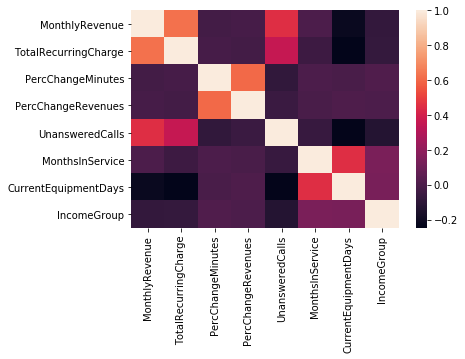

In [397]:
cor_mat = data[num_cols].corr()
sns.heatmap(cor_mat)

In [398]:
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
for col in num_cols:
    print("==============> ", col)
    data[col+'_quantile_label'] = pd.qcut(data[col], q=quantile_list, labels=quantile_labels)

==============>  MonthlyRevenue
==============>  TotalRecurringCharge
==============>  PercChangeMinutes
==============>  PercChangeRevenues
==============>  UnansweredCalls
==============>  MonthsInService
==============>  CurrentEquipmentDays
==============>  IncomeGroup


In [399]:
log_col = ['MonthlyRevenue', 'DirectorAssistedCalls', 'RoamingCalls', 'UnansweredCalls', 'CustomerCareCalls','ThreewayCalls', 
           'BlockedCalls', 'CallWaitingCalls', 'CallForwardingCalls', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels',
           'RetentionCalls', 'MonthsInService', 'AdjustmentsToCreditRating' ]

for col in log_col:
    print("==============> ", col)
    data[col+'_log'] = np.log1p(data[col])

==============>  MonthlyRevenue
==============>  DirectorAssistedCalls
==============>  RoamingCalls
==============>  UnansweredCalls
==============>  CustomerCareCalls
==============>  ThreewayCalls
==============>  BlockedCalls
==============>  CallWaitingCalls
==============>  CallForwardingCalls
==============>  UniqueSubs
==============>  ActiveSubs
==============>  Handsets
==============>  HandsetModels
==============>  RetentionCalls
==============>  MonthsInService
==============>  AdjustmentsToCreditRating


In [400]:
mean_encoder_columns = ['MadeCallToRetentionTeam' , 'HandsetWebCapable', 'BuysViaMailOrder' , 'RespondsToMailOffers', 'OwnsMotorcycle',
            'HandsetPrice', 'CreditRating', 'Occupation', 'MaritalStatus', "Handsets",
            "HandsetModels", "CurrentEquipmentDays", "AgeHH1", "AgeHH2"]
        
## Mean encoding 
for col in mean_encoder_columns:
    encoding_x = data.groupby([col])['Churn'].count().reset_index()
    encoding_x = encoding_x.rename(columns={'Churn' : "sum"})
    
    encoding_y = data.groupby([col])['Churn'].count().reset_index()
    encoding_y = encoding_y.rename(columns={'Churn' : "count"})
   
    encoding_z = pd.merge(encoding_x, encoding_y, on = col, how = 'inner')
    encoding_z[col+'_mean_encoded'] = (encoding_z['sum'].astype(int)/encoding_z['count'].astype(int))
     
    encoding_z = encoding_z[[col, col+'_mean_encoded']]
    data = pd.merge(data, encoding_z, on = col, how = 'left')

In [401]:
print(list(data.columns))

['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser', 'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'OwnsMotorcycle', 'AdjustmentsToCreditRating', 'HandsetPrice', 'MadeCallToRetentionTeam', 'C

In [402]:
from sklearn.model_selection import train_test_split

def imbalance_data_train_test_split(dataset, target_varibale, test_spit_size=0.20):
    seed = 41
    
    data_positive_class = dataset[dataset[target_varibale] == 'Yes']
    data_negative_class = dataset[dataset[target_varibale] == 'No']
    print("data_positive_class shape: ", data_positive_class.shape, "\ndata_negative_class shape: ", data_negative_class.shape)
    
    X_data_positive_class = data_positive_class.drop(target_varibale, axis=1)
    Y_data_positive_class = data_positive_class[[target_varibale]]
    X_data_positive_class_train, X_data_positive_class_test, Y_data_positive_class_train, Y_data_positive_class_test = train_test_split(X_data_positive_class, Y_data_positive_class, test_size=test_spit_size, random_state=seed)

    X_data_negative_class = data_negative_class.drop(target_varibale, axis=1)
    Y_data_negative_class = data_negative_class[[target_varibale]]
    X_data_negative_class_train, X_data_negative_class_test, Y_data_negative_class_train, Y_data_negative_class_test = train_test_split(X_data_negative_class, Y_data_negative_class, test_size=test_spit_size, random_state=seed)


    X_train = pd.concat([X_data_positive_class_train, X_data_negative_class_train], axis=0)
    y_train = pd.concat([Y_data_positive_class_train, Y_data_negative_class_train], axis=0)
    X_test = pd.concat([X_data_positive_class_test, X_data_negative_class_test], axis=0)
    y_test = pd.concat([Y_data_positive_class_test, Y_data_negative_class_test], axis=0)

    print(X_train.shape[0]+X_test.shape[0], y_train.shape[0]+y_test.shape[0])
    
    return X_train, X_test, y_train, y_test

def column_name_special_char_handling(train, test):
    traincol = train.columns
    testcol = test.columns

    new_train_col = []
    for col in traincol:
        new_train_col.append(col.replace("/", "").replace("(", "").replace(")", "").replace("?", "").replace(" ", "_"))
    train.columns = new_train_col
    
    new_test_col = []
    for col in testcol:
        new_test_col.append(col.replace("/", "").replace("(", "").replace(")", "").replace("?", "").replace(" ", "_"))
    test.columns = new_test_col
    
    return train, test

def train_test_data_for_platform(X_train, X_test, y_train, y_test):
    
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    #train, test = column_name_special_char_handling(train_data, test_data)
    train = train_data
    test = test_data
    
    print("train_data shape : ",train.shape, "\ntest_data shape : ",test.shape)
    
    return train, test

In [403]:
target_varibale = 'Churn'

X_train, X_test, y_train, y_test = imbalance_data_train_test_split(data, target_varibale, test_spit_size=0.20)
_train_data, _test_data = train_test_data_for_platform(X_train, X_test, y_train, y_test)

data_positive_class shape:  (14245, 96) 
data_negative_class shape:  (35507, 96)
49752 49752
train_data shape :  (39801, 96) 
test_data shape :  (9951, 96)


In [404]:
print(_train_data[_train_data[target_varibale]=='Yes'].shape)
print(_train_data[_train_data[target_varibale]=='No'].shape)
print(_test_data[_test_data[target_varibale]=='Yes'].shape)
print(_test_data[_test_data[target_varibale]=='No'].shape)

(11396, 96)
(28405, 96)
(2849, 96)
(7102, 96)


In [405]:
train = _train_data
test = _test_data

In [406]:
train.columns

Index(['CustomerID', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup',
    

In [417]:
print(train.columns)

boost_col = ['Churn', 'MadeCallToRetentionTeam' , 'HandsetWebCapable', 'BuysViaMailOrder' , 'RespondsToMailOffers', 'OwnsMotorcycle',
            'HandsetPrice', 'CreditRating', 'Occupation', 'MaritalStatus', "Handsets",
            "HandsetModels", "CurrentEquipmentDays", "AgeHH1", "AgeHH2",
             
            'MonthlyRevenue_quantile_label', 'TotalRecurringCharge_quantile_label',
            'PercChangeMinutes_quantile_label', 'PercChangeRevenues_quantile_label',
            'UnansweredCalls_quantile_label', 'MonthsInService_quantile_label',
            'CurrentEquipmentDays_quantile_label', 'IncomeGroup_quantile_label',
             
            'MonthlyRevenue_log', 'DirectorAssistedCalls_log', 'RoamingCalls_log',
            'UnansweredCalls_log', 'CustomerCareCalls_log', 'ThreewayCalls_log',
            'BlockedCalls_log', 'CallWaitingCalls_log', 'CallForwardingCalls_log',
            'UniqueSubs_log', 'ActiveSubs_log', 'Handsets_log', 'HandsetModels_log',
            'RetentionCalls_log', 'MonthsInService_log',
            'AdjustmentsToCreditRating_log',
             
            'MadeCallToRetentionTeam_mean_encoded',
            'HandsetWebCapable_mean_encoded', 'BuysViaMailOrder_mean_encoded',
            'RespondsToMailOffers_mean_encoded', 'OwnsMotorcycle_mean_encoded',
            'HandsetPrice_mean_encoded', 'CreditRating_mean_encoded',
            'Occupation_mean_encoded', 'MaritalStatus_mean_encoded',
            'Handsets_mean_encoded', 'HandsetModels_mean_encoded',
            'CurrentEquipmentDays_mean_encoded', 'AgeHH1_mean_encoded',
            'AgeHH2_mean_encoded'
             
           ]

target_flag = target_varibale

Index(['CustomerID', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup',
    

In [418]:
for i,col in enumerate(boost_col):
    data_type = str(train[col].dtypes)
    #print("\n===============>",col, data_type)
    if(( data_type == "object") or (data_type == "category")):
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col].astype(str))
        #print(le.classes_)

        test[col] = test[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, '<unknown>')

        test[col] = le.transform(test[col])

In [419]:
print(train.shape)
train.head(3)

(39801, 96)


,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,HandsetPrice_mean_encoded,CreditRating_mean_encoded,Occupation_mean_encoded,MaritalStatus_mean_encoded,Handsets_mean_encoded,HandsetModels_mean_encoded,CurrentEquipmentDays_mean_encoded,AgeHH1_mean_encoded,AgeHH2_mean_encoded,Churn
23555,3188958,60.70,1027.0,63.0,1.49,0.0,0.0,-596.0,-63.5,6.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
31936,3259114,111.19,1509.0,54.0,4.46,141.0,0.0,361.0,111.5,10.7,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
22032,3176510,48.88,1033.0,45.0,0.50,34.0,0.0,-95.0,30.5,6.7,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [420]:
print(test.shape)
test.head(3)

(9951, 96)


,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,HandsetPrice_mean_encoded,CreditRating_mean_encoded,Occupation_mean_encoded,MaritalStatus_mean_encoded,Handsets_mean_encoded,HandsetModels_mean_encoded,CurrentEquipmentDays_mean_encoded,AgeHH1_mean_encoded,AgeHH2_mean_encoded,Churn
37124,3302050,19.99,0.0,30.0,0.00,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
16828,3134386,35.24,458.0,45.0,0.25,0.0,0.0,-185.0,-0.2,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
23499,3188542,53.44,9.0,60.0,0.00,0.0,0.0,-9.0,-0.4,0.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [421]:
X_train = train[boost_col]
y_train = train[target_flag]

X_test = test[boost_col]
y_test = test[target_flag]

## Metrices

In [422]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score, cohen_kappa_score, average_precision_score
def metrices(_type, rf_y_train, rf_y_train_pred, rf_y_train_pred_score):
    print(_type+" Accuracy:",accuracy_score(rf_y_train, rf_y_train_pred))
    print(_type+" f1_score:",f1_score(rf_y_train, rf_y_train_pred))
    print(_type+" precision_score:",precision_score(rf_y_train, rf_y_train_pred))
    print(_type+" recall_score:",recall_score(rf_y_train, rf_y_train_pred)) 
    print(_type+" Cohens kappa:",cohen_kappa_score(rf_y_train, rf_y_train_pred))
    print(_type+" ROC AUC:",roc_auc_score(rf_y_train, rf_y_train_pred))
    print(_type+" confusion_matrix:\n",confusion_matrix(rf_y_train, rf_y_train_pred))
    print(_type+" Average precision-recall score: {0:0.2f}".format(average_precision_score(rf_y_train, rf_y_train_pred_score)))

In [423]:
"""
modified_predictors = num_cols
#, 'N_Proportion', 'Y_Proportion'
modified_numeric_col = num_cols #list(set(modified_predictors))
modified_chi_square_splits = ChiSquareSplits(data, modified_numeric_col)
modified_splits = modified_chi_square_splits.get_splits()
modified_splits.head()
"""

"\nmodified_predictors = num_cols\n#, 'N_Proportion', 'Y_Proportion'\nmodified_numeric_col = num_cols #list(set(modified_predictors))\nmodified_chi_square_splits = ChiSquareSplits(data, modified_numeric_col)\nmodified_splits = modified_chi_square_splits.get_splits()\nmodified_splits.head()\n"

In [424]:
print(sum(y_train == 1))
print(sum(y_train == 0))
print(len(y_train), sum(y_train == 1)+sum(y_train == 0))
print(len(y_train), sum(y_train == 1)+sum(y_train == 0))
cal_scale_pos_weight = sum(y_train == 0)/sum(y_train == 1)
print(cal_scale_pos_weight)

11396
28405
39801 39801
39801 39801
2.4925412425412428


## XGBClassifier

In [427]:
xgb_predictors = [
            'MadeCallToRetentionTeam' , 'HandsetWebCapable', 'BuysViaMailOrder' , 'RespondsToMailOffers', 'OwnsMotorcycle',
            'HandsetPrice', 'CreditRating', 'Occupation', 'MaritalStatus', 
            "Handsets", "HandsetModels", "CurrentEquipmentDays", "AgeHH1", "AgeHH2",
                  
            'MonthlyRevenue_quantile_label', 'TotalRecurringCharge_quantile_label',
            'PercChangeMinutes_quantile_label', 'PercChangeRevenues_quantile_label',
            'UnansweredCalls_quantile_label', 'MonthsInService_quantile_label',
            'CurrentEquipmentDays_quantile_label', 'IncomeGroup_quantile_label',
                  
            'MonthlyRevenue_log', 'DirectorAssistedCalls_log', 'RoamingCalls_log',
            'UnansweredCalls_log', 'CustomerCareCalls_log', 'ThreewayCalls_log',
            'BlockedCalls_log', 'CallWaitingCalls_log', 'CallForwardingCalls_log',
            'UniqueSubs_log', 'ActiveSubs_log', 'Handsets_log', 'HandsetModels_log',
            'RetentionCalls_log', 'MonthsInService_log',
            'AdjustmentsToCreditRating_log',
            
            
            #'MadeCallToRetentionTeam_mean_encoded', 'HandsetWebCapable_mean_encoded', 'BuysViaMailOrder_mean_encoded',
            #'RespondsToMailOffers_mean_encoded', 'OwnsMotorcycle_mean_encoded', 'HandsetPrice_mean_encoded', 
            #'CreditRating_mean_encoded', 'Occupation_mean_encoded', 'MaritalStatus_mean_encoded', 'Handsets_mean_encoded', 
            #'HandsetModels_mean_encoded', 'CurrentEquipmentDays_mean_encoded', 'AgeHH1_mean_encoded', 'AgeHH2_mean_encoded'
            
           ]

xgb_X_train = X_train[xgb_predictors]
xgb_y_train = y_train

xgb_X_test = X_test[xgb_predictors]
xgb_y_test = y_test


param_test1 = {
    'max_depth':[5,7,9],
    'min_child_weight':range(1,6,2),
    "max_depth": [5,7,9],
    "min_samples_split" : [8, 10, 12],
    #"max_features": np.arange(1, 9),
    #"min_samples_leaf": np.arange(1, 9),
    "criterion": ["gini", "entropy"]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.1, colsample_bytree=0.8, #eval_metric = 'aucpr',
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch1.fit(xgb_X_train, xgb_y_train)


#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#xgb_model = gsearch1.best_estimator_  #'reg:logistic' 'binary:logistic'

xgb_modelfit = XGBClassifier(learning_rate =0.08, n_estimators=200, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.8, eval_metric = 'aucpr', #'aucpr',
 objective= 'reg:logistic', nthread=4, scale_pos_weight=2.1, seed=27)
xgb_model = xgb_modelfit.fit(xgb_X_train, xgb_y_train)


# Traning data
rf_y_train = xgb_y_train
rf_y_train_pred = xgb_model.predict(xgb_X_train)
rf_y_train_pred_score = xgb_model.predict_proba(xgb_X_train)
rf_y_train_pred_score = rf_y_train_pred_score[:, 1]

# Test data
rf_y_test = xgb_y_test
rf_y_pred = xgb_model.predict(xgb_X_test)
rf_y_pred_score = xgb_model.predict_proba(xgb_X_test)
rf_y_pred_score = rf_y_pred_score[:, 1]

metrices("Train", rf_y_train, rf_y_train_pred, rf_y_train_pred_score)
print('\n\n')
metrices("Test", rf_y_test, rf_y_pred, rf_y_pred_score)

feature_score = feature_score = pd.DataFrame(list(zip(xgb_X_train.dtypes.index, xgb_model.feature_importances_*100)),
                columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
feature_score

Train Accuracy: 0.7777442777819653
Train f1_score: 0.6487173377809546
Train precision_score: 0.5924851298418685
Train recall_score: 0.7167427167427167
Train Cohens kappa: 0.4882996668290899
Train ROC AUC: 0.7594803180615538
Train confusion_matrix:
 [[22787  5618]
 [ 3228  8168]]
Train Average precision-recall score: 0.71



Test Accuracy: 0.6529996985227615
Test f1_score: 0.44189429448844353
Test precision_score: 0.40952666267225885
Test recall_score: 0.4798174798174798
Test Cohens kappa: 0.19240197285288363
Test ROC AUC: 0.6011450113815644
Test confusion_matrix:
 [[5131 1971]
 [1482 1367]]
Test Average precision-recall score: 0.41


,Feature,Score
20,CurrentEquipmentDays_quantile_label,7.060602
0,MadeCallToRetentionTeam,5.440672
36,MonthsInService_log,4.493007
35,RetentionCalls_log,4.255929
11,CurrentEquipmentDays,3.766349
15,TotalRecurringCharge_quantile_label,3.558258
1,HandsetWebCapable,3.413870
14,MonthlyRevenue_quantile_label,2.989133
31,UniqueSubs_log,2.691492
6,CreditRating,2.607093


#### XGB Shapely Additive Explaination

In [ ]:
# DF, based on which importance is checked
xgb_importance = xgb_X_train # 
#xgb_importance = xgb_X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(xgb_importance)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
# Plot summary_plot
shap.summary_plot(shap_values, xgb_importance)